In [2]:
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import matplotlib


1.48578574719


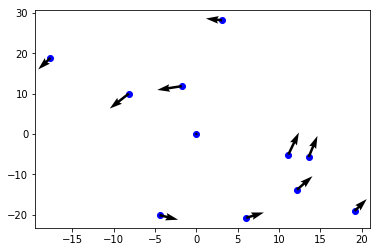

In [3]:
# hmotnost [mE] a rozmer [AU] shluku asteroidu
m_a = 14
l_a = 1
# hmotnost a rozmer slunce
m_S = 333000
l_S = 1e-4


# gravitacni konstanta 
AU = 150e9               # meters
year = 365 * 24 * 3600   # sec
m_earth = 5.972e24       # kg
#G = 6.7e-11 / AU**3 / m_earth * year ** 2    # AU^3 mE^-1 year ^-2
G = 4*np.pi**2 / m_S


def make_init(N, a, b):
    
    angle = np.random.uniform(0, 2*np.pi, N)
    r = np.random.uniform(a,b, N)
    scale = np.sqrt( G * m_S) 
    v_abs = scale*np.sqrt( 1.0 / r )
    v_err = 0.01 * v_abs[:,None] * np.random.randn(N, 2)
    pos = np.stack( (r*np.cos(angle), r*np.sin(angle)), axis=1 )
    vel = np.stack( (-v_abs*np.sin(angle) + v_err[:, 0], v_abs*np.cos(angle) + v_err[:, 1] ), axis=1)
    # constant wight
    m = m_a*np.ones(N)
    # diameter, irrelevant witout collisions
    l = l_a*np.ones(N)
    phase_vec = np.c_[ pos, vel, m[:,None] , l[:,None]]
    
    sun = np.array([ 0, 0, 0, 0, m_S, l_S])
    return np.r_[ sun[None, :], phase_vec ]     


phase_0 = make_init(10, 10, 30)
X = phase_0[:, 0]
Y = phase_0[:, 1]
U = phase_0[:, 2]
V = phase_0[:, 3]

print(np.mean( np.linalg.norm(phase_0[1:,2:4], axis=1), axis=0))
plt.scatter(X, Y, c='blue')
plt.quiver(X, Y, U, V)
plt.show()


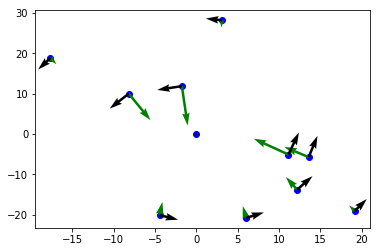

In [12]:
def force(phase_vec, t):    
    phase = phase_vec.reshape((-1, 6))
    pos  = phase[:, 0:2]
    m = phase[:, 4]
    phase_dot = np.empty_like(phase)
    phase_dot[:,0:2] = phase[:, 2:4]
                
    for k in range(len(pos)):
        m0 = m[k]
        r0 = pos[k, :]
        r = pos - r0
        r2 = np.sum(r*r, axis=1)
        r2[k] = 1.0        
        force_vec = m[:, None] * r * (r2[:, None] ** -1.5)
        body_force = G * np.sum( force_vec, axis=0 )
        phase_dot[k,2:4] = body_force

    phase_dot[0, :] = 0.0
    phase_dot[:, 4:6] = 0.0
    return phase_dot.ravel()



force_0 = force(phase_0.ravel(), 0).reshape(-1, 6)
X = phase_0[:, 0]
Y = phase_0[:, 1]
FU = force_0[:, 2]
FV = force_0[:, 3]

plt.scatter(X, Y, c='blue')
plt.quiver(X, Y, FU, FV, color='g')
plt.quiver(X, Y, U, V)
plt.show()
        

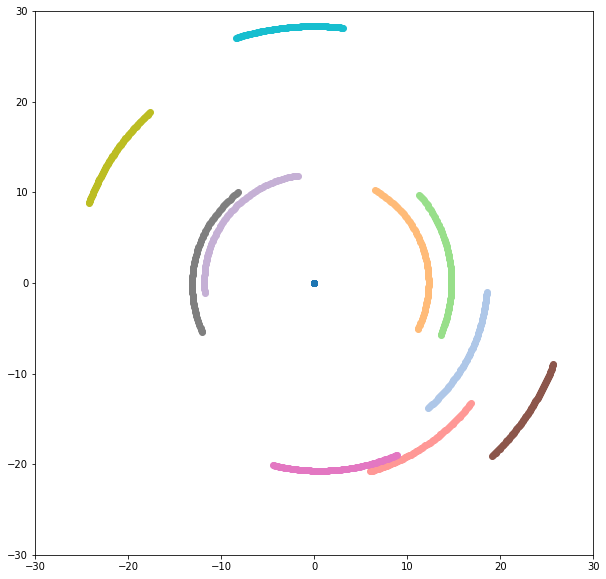

[[  0.           0.           0.           0.        ]
 [ 12.18826463 -13.80246461   1.11277067   0.97998834]
 [ 11.13357827  -5.09425415   0.76287801   1.60274912]
 [ 13.58401488  -5.73584378   0.63829137   1.53967882]
 [  6.02917015 -20.78849682   1.28828016   0.39126031]
 [ -1.75315164  11.85931252  -1.78573506  -0.27658777]
 [ 19.15458474 -19.07439557   0.87568575   0.86227906]
 [ -4.45472139 -20.10623402   1.35204743  -0.33464541]
 [ -8.18035807  10.00452051  -1.37664003  -1.0848368 ]
 [-17.64547916  18.84503818  -0.89501782  -0.83510501]
 [  3.107846    28.17520909  -1.17414472   0.12927127]]
[[[  0.           0.           0.           0.        ]
  [ 12.18826463 -13.80246461   1.11277067   0.97998834]
  [ 11.13357827  -5.09425415   0.76287801   1.60274912]
  ..., 
  [ -8.18035807  10.00452051  -1.37664003  -1.0848368 ]
  [-17.64547916  18.84503818  -0.89501782  -0.83510501]
  [  3.107846    28.17520909  -1.17414472   0.12927127]]

 [[  0.           0.           0.           0.  

In [16]:
# Evaluation times [year]
n_bodies = phase_0.shape[0]
times = np.arange(0, 10, 0.1)
result = sci.odeint(force, phase_0.ravel(), times)
result.shape = (len(times), n_bodies, 6)

norm  = mcolors.Normalize(0, n_bodies)
col_map = matplotlib.cm.get_cmap('tab20')

plt.figure(figsize=(10,10))
for k in range(n_bodies):
    X = result[:,k,0]
    Y = result[:,k,1]
    cc = col_map(norm(k))
    plt.scatter(X, Y, c=cc)

plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

print(phase_0[:, 0:4])
print(result[:, :, 0:4])
